# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [115]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [114]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
azdias.shape

(891221, 85)

In [4]:
feat_info.shape

(85, 4)

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# list of value that encode a missing values
feat_info.shape

(85, 4)

In [9]:
# total number of missing (na) value in the dataset
azdias.isna().sum().sum()

4896838

In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
values_that_encode_nan = feat_info.missing_or_unknown.unique()
values_that_encode_nan

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [12]:
# loop on each feature
#   retrieve the values that code a missing or unknown value from the feat_info
#   loop on those unknown or missing values
#     replace (inplace=True) them in azdias with NaN
#reading the panda doc, I found this 'where' function that does the job...



In [13]:
#azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
for idx in range(0,feat_info.shape[0]):
    attribute = feat_info['attribute'][idx]
    print(attribute)
    vals = feat_info['missing_or_unknown'][idx].replace("[","").replace("]","").split(",")
    for val in vals:
        print('Replacing: {}'.format(val))
        if (val == 'X' or val == 'XX' or val == ''):
            azdias[attribute].where(azdias[attribute] != val, inplace=True)
        else:
            azdias[attribute].where(azdias[attribute] != int(val), inplace=True)


    
#azdias[attribute] 

AGER_TYP
Replacing: -1
Replacing: 0
ALTERSKATEGORIE_GROB
Replacing: -1
Replacing: 0
Replacing: 9
ANREDE_KZ
Replacing: -1
Replacing: 0
CJT_GESAMTTYP
Replacing: 0
FINANZ_MINIMALIST
Replacing: -1
FINANZ_SPARER
Replacing: -1
FINANZ_VORSORGER
Replacing: -1
FINANZ_ANLEGER
Replacing: -1
FINANZ_UNAUFFAELLIGER
Replacing: -1
FINANZ_HAUSBAUER
Replacing: -1
FINANZTYP
Replacing: -1
GEBURTSJAHR
Replacing: 0
GFK_URLAUBERTYP
Replacing: 
GREEN_AVANTGARDE
Replacing: 
HEALTH_TYP
Replacing: -1


C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Replacing: 0
LP_LEBENSPHASE_FEIN
Replacing: 0
LP_LEBENSPHASE_GROB
Replacing: 0
LP_FAMILIE_FEIN
Replacing: 0
LP_FAMILIE_GROB
Replacing: 0
LP_STATUS_FEIN
Replacing: 0
LP_STATUS_GROB
Replacing: 0
NATIONALITAET_KZ
Replacing: -1
Replacing: 0
PRAEGENDE_JUGENDJAHRE
Replacing: -1
Replacing: 0
RETOURTYP_BK_S
Replacing: 0
SEMIO_SOZ
Replacing: -1
Replacing: 9
SEMIO_FAM
Replacing: -1
Replacing: 9
SEMIO_REL
Replacing: -1
Replacing: 9
SEMIO_MAT
Replacing: -1
Replacing: 9
SEMIO_VERT
Replacing: -1
Replacing: 9
SEMIO_LUST
Replacing: -1
Replacing: 9
SEMIO_ERL
Replacing: -1
Replacing: 9
SEMIO_KULT
Replacing: -1
Replacing: 9
SEMIO_RAT
Replacing: -1
Replacing: 9
SEMIO_KRIT
Replacing: -1
Replacing: 9
SEMIO_DOM
Replacing: -1
Replacing: 9
SEMIO_KAEM
Replacing: -1
Replacing: 9
SEMIO_PFLICHT
Replacing: -1
Replacing: 9
SEMIO_TRADV
Replacing: -1
Replacing: 9
SHOPPER_TYP
Replacing: -1
SOHO_KZ
Replacing: -1
TITEL_KZ
Replacing: -1
Replacing: 0
VERS_TYP
Replacing: -1
ZABEOTYP
Replacing: -1
Replacing: 9
ALTER_HH
Repla

In [14]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
# now that we have changed the missing or unknown value by NaN, we can count again
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isna().sum()
missing_data.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [17]:
missing_data_percent = missing_data/len(azdias)

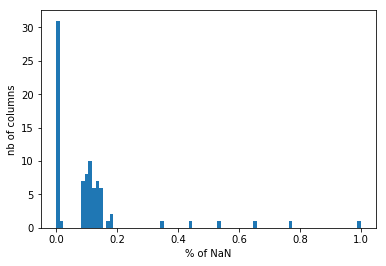

In [18]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data_percent, bins=missing_data_percent.shape[0])
plt.xlabel('% of NaN')
plt.ylabel('nb of columns')
plt.show()

In [19]:
missing_data_percent.sort_values(ascending=False).head(6)

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [20]:
(missing_data_percent>0.3).sum()

6

In [21]:
drop_columns = missing_data_percent[missing_data_percent>0.3].index.tolist()
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(columns = drop_columns, axis=1, inplace=True)

In [23]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The histogram showing repartition of NaN (missing values) is pretty impressive.
There is more than 30 columns with no missing values.
But there is also 6 columns that are having lots of missing value. One column (TITEL_KZ) is almost empty (99 percent missing values).
I decided to cut at 0.3 and remove the 6 columns (drop_columns)



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isna().sum(axis=1)
missing_row_percent = missing_row / azdias.shape[1]
missing_row_percent.describe()

count    891221.000000
mean          0.071518
std           0.167528
min           0.000000
25%           0.000000
50%           0.000000
75%           0.037975
max           0.620253
dtype: float64

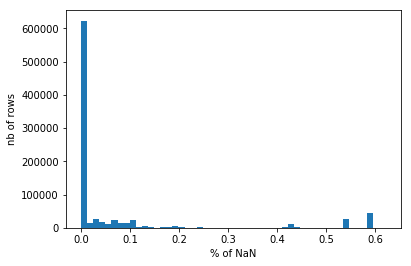

In [25]:
plt.hist(missing_row_percent,bins=50)
plt.xlabel('% of NaN')
plt.ylabel('nb of rows')
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Looks like fro mthe histogram that we can cut at 0.3
azdias_low = azdias[missing_row_percent <= 0.3]
azdias_high = azdias[missing_row_percent > 0.3]

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols = missing_data[missing_data==0].index.tolist()#[:5]
cols

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [28]:
def plot_compare(column):
    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.title.set_text('no missing rows')
    sns.countplot(azdias_low[col])

    ax2 = fig.add_subplot(1,2,2)
    ax2.title.set_text('missing rows')
    sns.countplot(azdias_high[col]);

    fig.suptitle(column)
    plt.show()

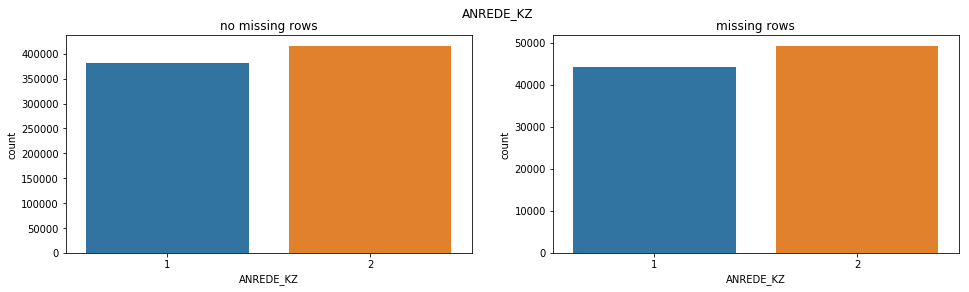

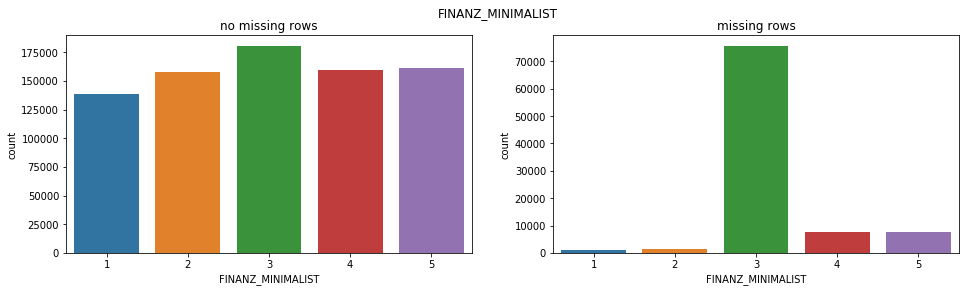

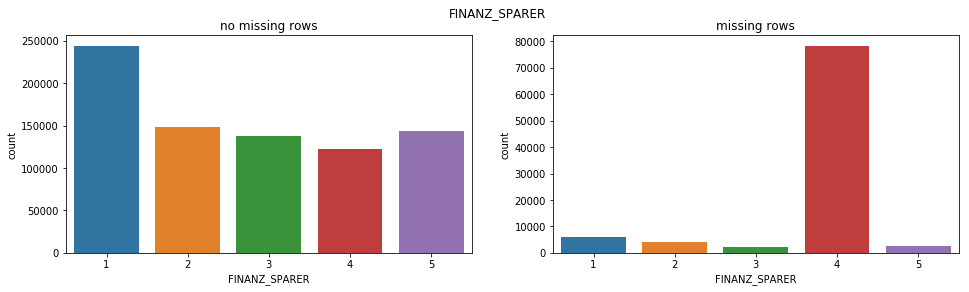

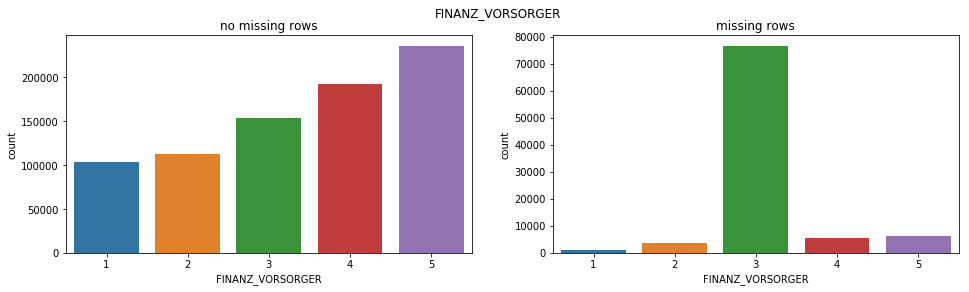

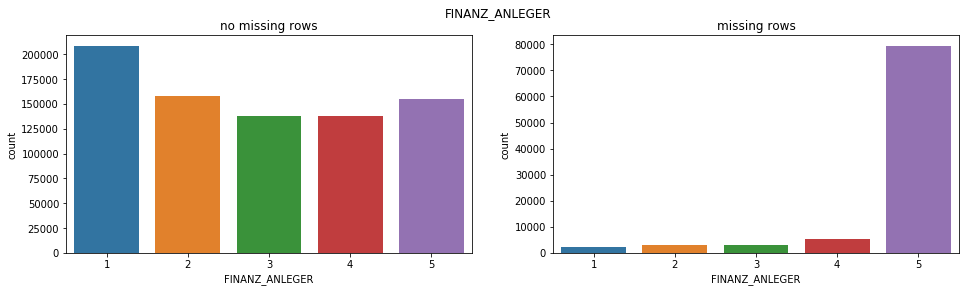

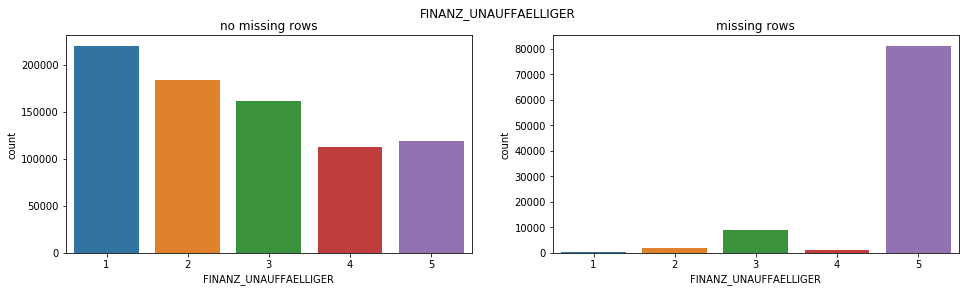

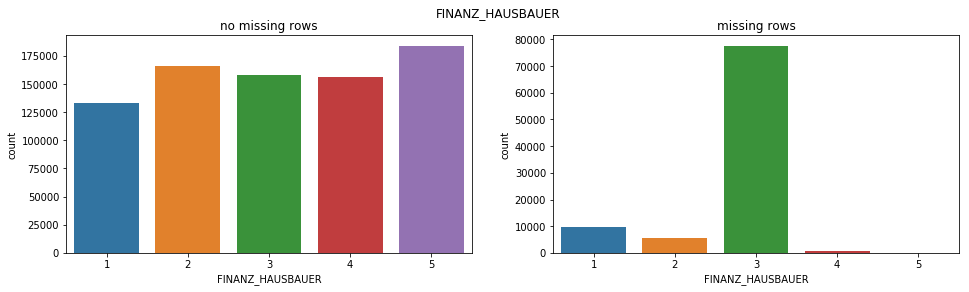

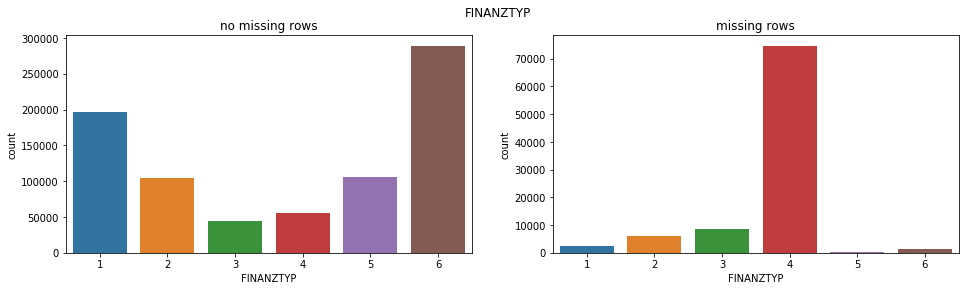

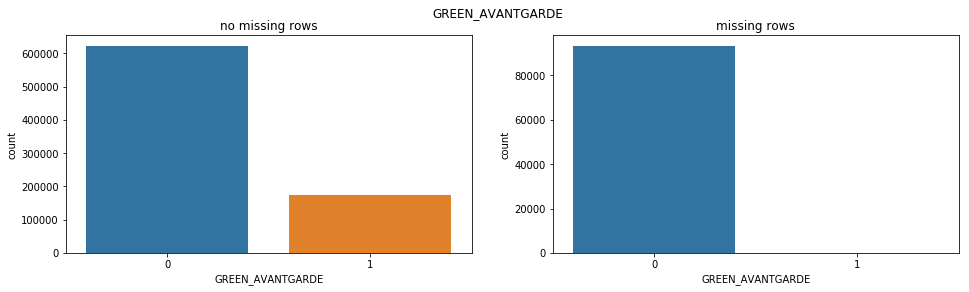

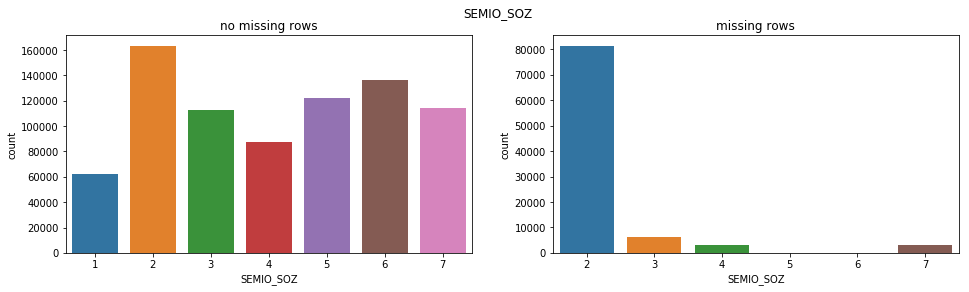

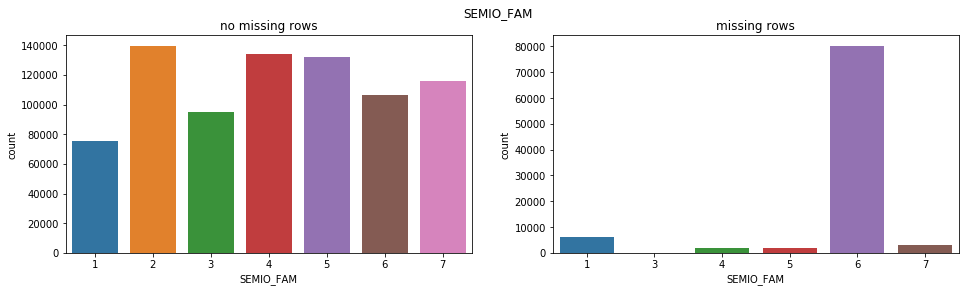

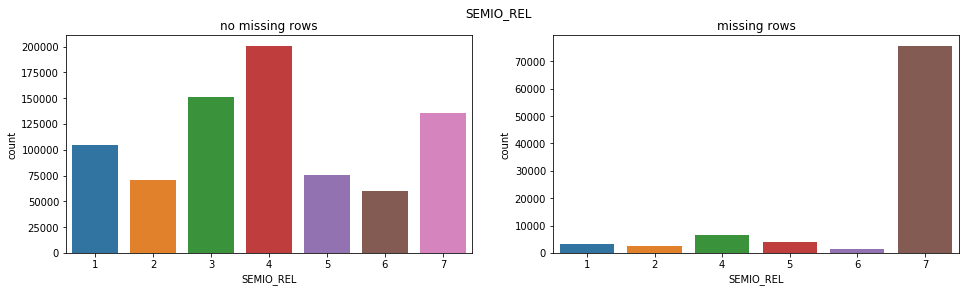

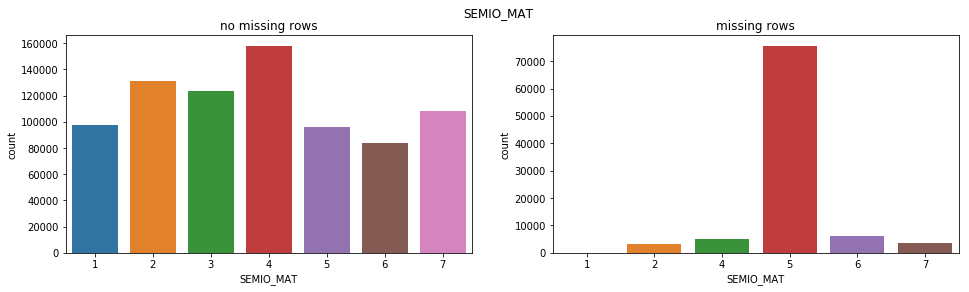

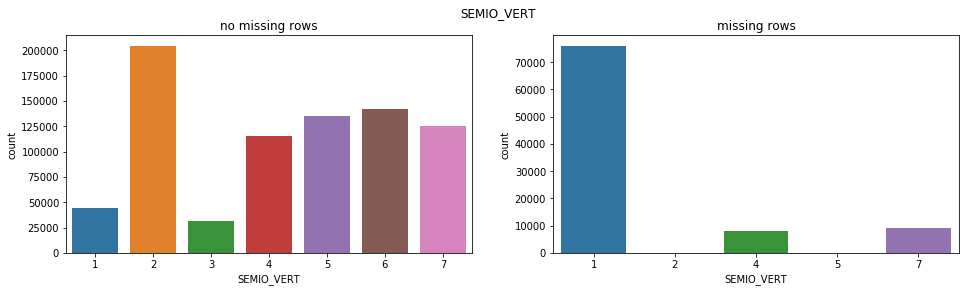

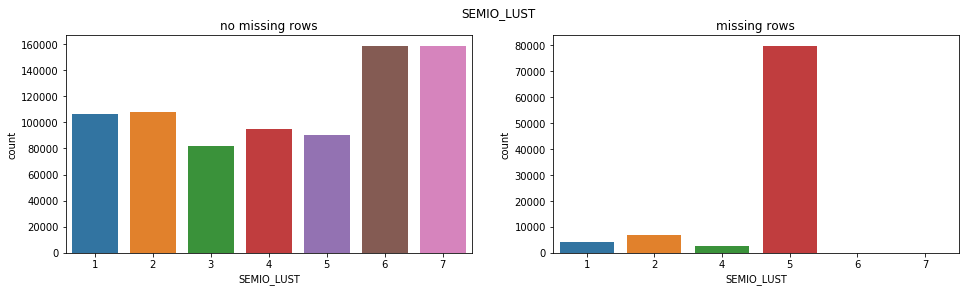

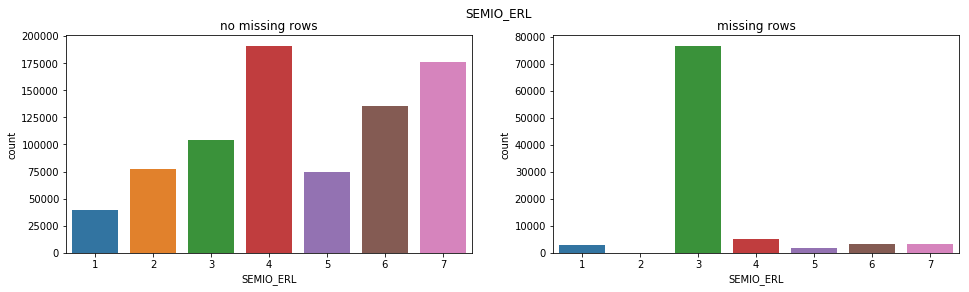

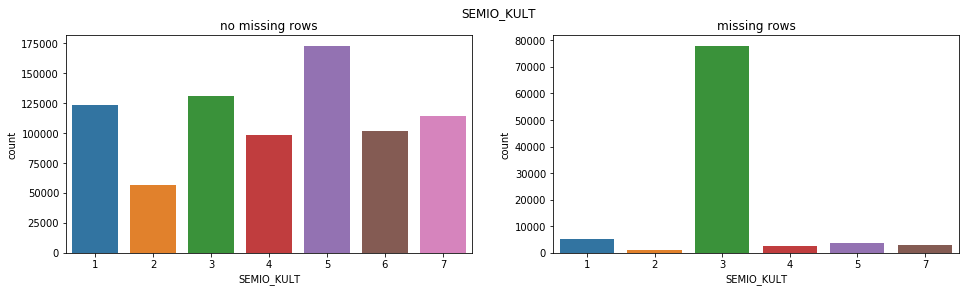

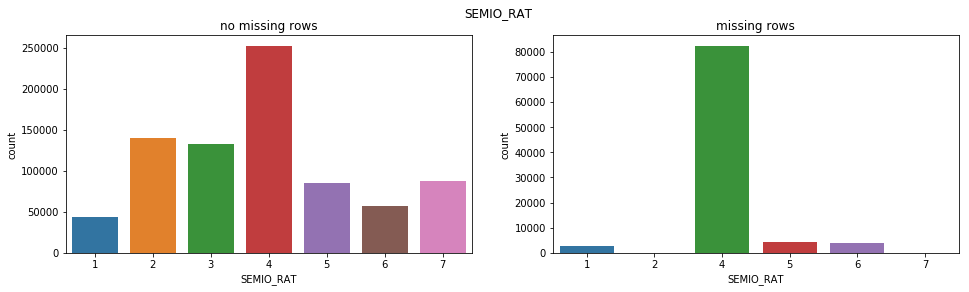

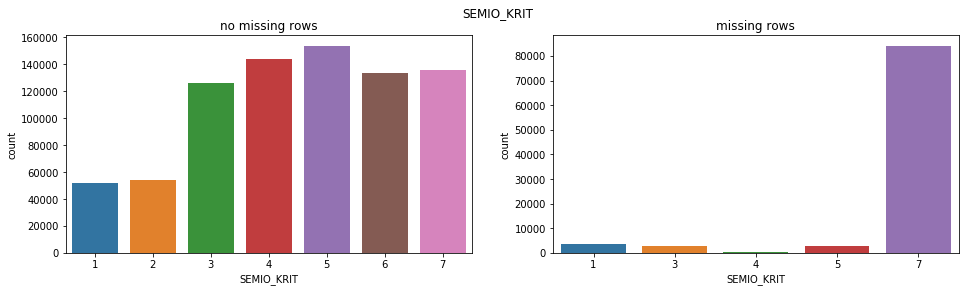

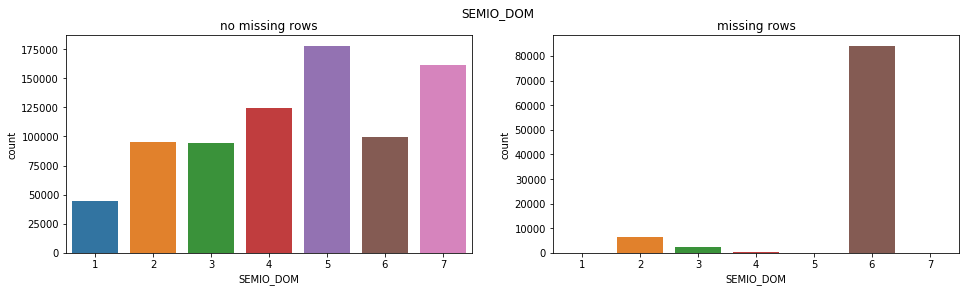

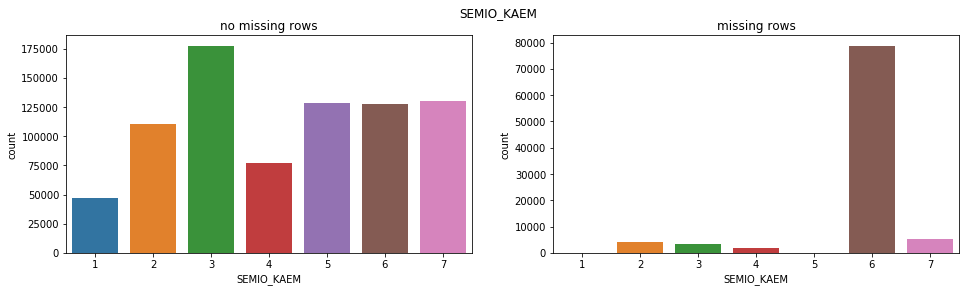

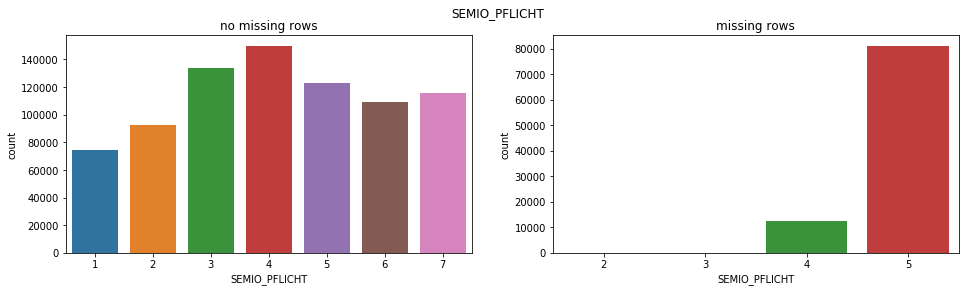

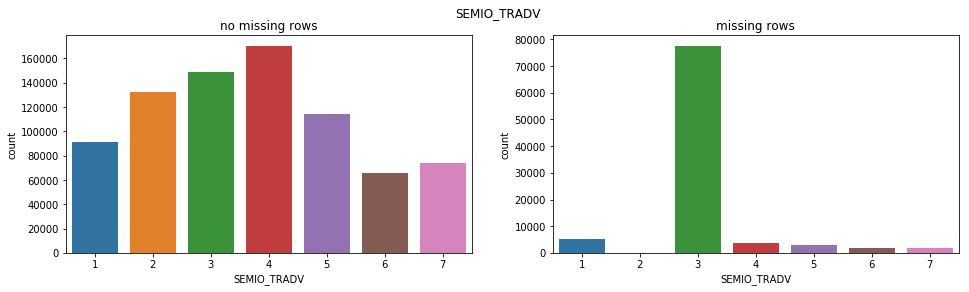

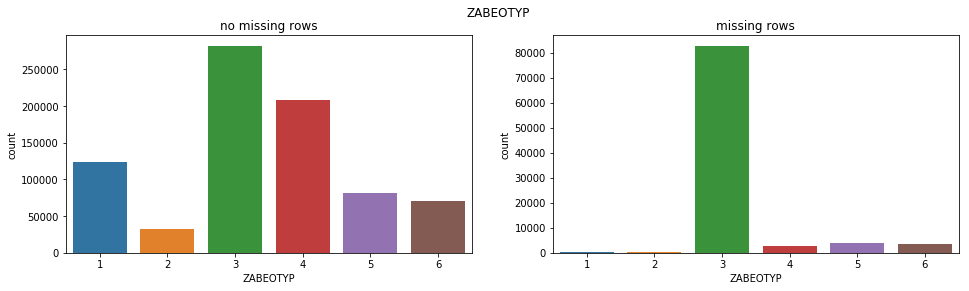

In [29]:
for col in cols:
    plot_compare(col)

In [33]:
# from review 2:
# Kolmogorov–Smirnov test 
from scipy.stats import ks_2samp
comp_df = pd.DataFrame(azdias.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_low, azdias_high, azdias_low.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df.head()


C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:4862: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / n2
C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in les

,col,stats,pvalues
0,ALTERSKATEGORIE_GROB,1.0,0.011066
1,ANREDE_KZ,1.0,0.097027
2,CJT_GESAMTTYP,1.0,0.001300
3,FINANZ_MINIMALIST,1.0,0.003781
4,FINANZ_SPARER,1.0,0.003781


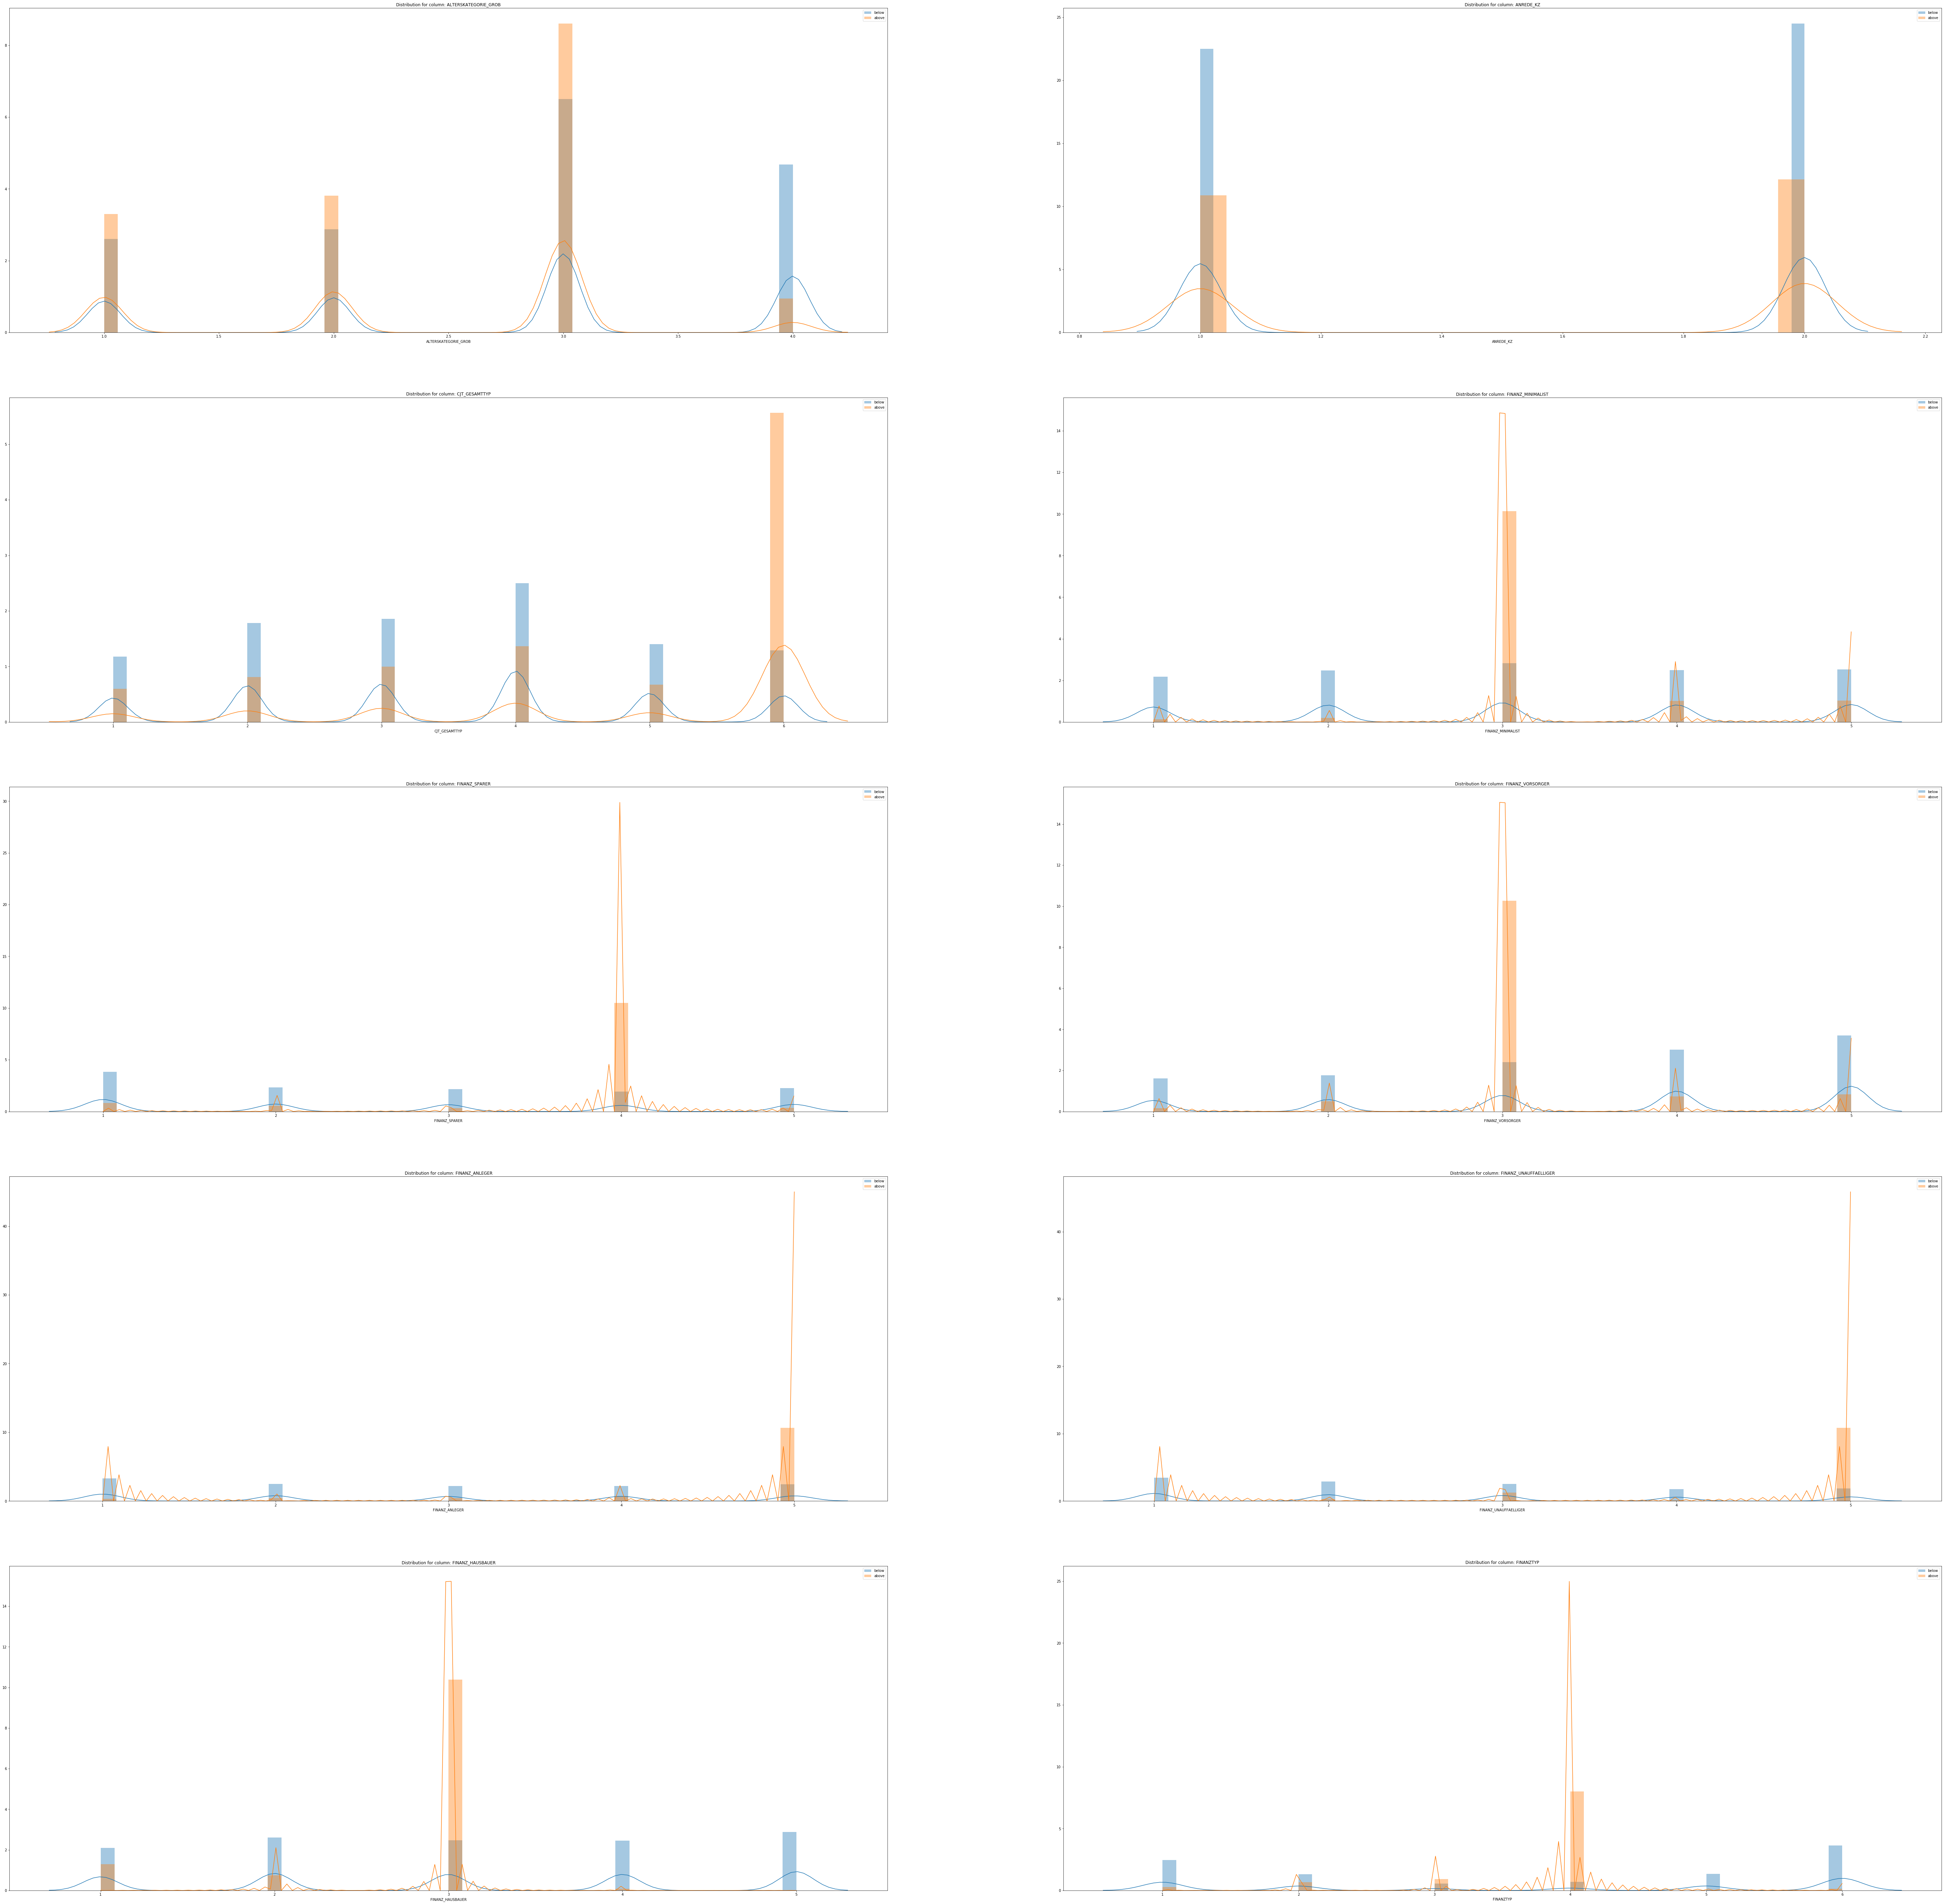

In [36]:
# from review 2:
plt.figure(figsize=(100,100))
for i, col in enumerate(azdias.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_low[col][azdias_low[col].notnull()], label='below')
    sns.distplot(azdias_high[col][azdias_high[col].notnull()], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Only SEMIO_SOZ and ANREDE_KZ looks similar out of the columns where there are no missing data.
It means they can both be dropped since this will not impact much as they are similar.
- ANREDE_KZ is sgender
- SEMIO_SOZ is socially-minded


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# we have been asked:
# Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.
# as we have already droped some columns in 1.1.2, we must not count them now
feat_info.type.value_counts() # this is total count

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [38]:
azdias_low.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [39]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [40]:
feat_info['attribute'].isin(azdias_low.columns).head()

0    False
1     True
2     True
3     True
4     True
Name: attribute, dtype: bool

In [41]:
# How many features are there of each data type?
feat_info = feat_info[feat_info['attribute'].isin(azdias_low.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
feat_info.shape

(79, 4)

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_features = []
multi_level_features = []
cat_variables = feat_info[feat_info.type == 'categorical']['attribute']

for var in cat_variables:
    nb_unique = len(azdias_low[var].unique())
    print('values found for {} : {}'.format(var, azdias_low[var].unique()))
    if nb_unique == 2:
        binary_features.append(var)
        #print('{} is binary'.format(var))
    else:
        multi_level_features.append(var)
        #print('{} is multi level'.format(var))

values found for ANREDE_KZ : [2 1]
values found for CJT_GESAMTTYP : [ 5.  3.  2.  4.  1.  6. nan]
values found for FINANZTYP : [1 6 5 2 4 3]
values found for GFK_URLAUBERTYP : [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
values found for GREEN_AVANTGARDE : [0 1]
values found for LP_FAMILIE_FEIN : [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
values found for LP_FAMILIE_GROB : [ 3.  1. nan  5.  2.  4.]
values found for LP_STATUS_FEIN : [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
values found for LP_STATUS_GROB : [ 1.  2.  4.  5.  3. nan]
values found for NATIONALITAET_KZ : [ 1.  3.  2. nan]
values found for SHOPPER_TYP : [ 3.  2.  1.  0. nan]
values found for SOHO_KZ : [1. 0.]
values found for VERS_TYP : [ 2.  1. nan]
values found for ZABEOTYP : [5 3 4 1 6 2]
values found for GEBAEUDETYP : [8. 1. 3. 2. 6. 4. 5.]
values found for OST_WEST_KZ : ['W' 'O']
values found for CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
values found for CAMEO_DEU_2015 : ['8A' '4C'

In [44]:
print('binary features are:')
print(*binary_features,sep='\n')
print('\nmulti level features are')
print(*multi_level_features,sep='\n')

binary features are:
ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
OST_WEST_KZ

multi level features are
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
VERS_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.
# don't touch the binary variables
# OST_WEST_KZ is binary but using non numeric value. Let's ren-encode that
OST_WEST_dict = {'W':0, 'O':1}
azdias_encoded = azdias_low.replace({'OST_WEST_KZ':OST_WEST_dict})

# encode multi-level variable with dummy variables
azdias_encoded = pd.get_dummies(azdias_encoded, columns=multi_level_features)


In [46]:
azdias_encoded.shape

(797837, 195)

In [47]:
for col in azdias_encoded.columns:
    print(col)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SOHO_KZ
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTY

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### I'm not sure if VERS_TYP : [ 2.  1. nan] is a binary feature or a categorical one.
Especially since there are some NaN.
Can you please explain me how this one should be treated? Thank you.

Edit: I know have the answer thanks to review 2
Well, it's both. Since you one-hot-encoded the VERS_TYP, your approach is correct.

There are different ways to handle Nan values. Either encode it to a 0 (if using one-hot-encoding), keep the value NaN and encode all missing values later, or you can create a new column called something like VERS_TYP_is_nan and if the value is Nan add a 1, then encode the original column to a 0 for Nan.


Otherwise, I decided to keep binary variables, and re-encode the Ost-West one.
Plus use get_dummies to encode all other multi level variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# here are the two new variable I will create: decade and movement
# decade will be able to take values from 1 to 6 (40s to 90s)
# movement will be binary: 0: mainstream, 1: avantgarde
# I will use dictionaries to map values from old to new variables
decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

azdias_encoded['DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)
azdias_encoded['MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)

In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_encoded['DECADE'].head()

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

In [50]:
azdias_encoded['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [51]:
azdias_encoded['MOVEMENT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: MOVEMENT, dtype: float64

In [52]:
# now, we need to drop the initial column PRAEGENDE_JUGENDJAHRE
#azdias_encoded = azdias_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
#edit I drop all mixed few cells below

In [53]:
azdias_encoded.shape

(797837, 197)

In [54]:
def map_wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

def map_life_stage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [55]:
# CAMEO_INTL_2015
# first digit is wealth, second digit is life_stage
azdias_encoded['WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].apply(map_wealth)
azdias_encoded['LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'].apply(map_life_stage)

In [56]:
# drop the initial column CAMEO_INTL_2015
#azdias_encoded = azdias_encoded.drop('CAMEO_INTL_2015', axis=1)
#edit I drop all mixed few cells below

In [57]:
azdias_encoded.shape

(797837, 199)

In [58]:
feat_info[feat_info.type == 'mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [59]:
# I decide to remove all mixed columns (according to the correction after first submission)
azdias_encoded = azdias_encoded.drop(feat_info[feat_info.type == 'mixed']['attribute'], axis=1)

In [60]:
azdias_encoded.shape

(797837, 193)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept all mixed value features.
Regarding PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I've splitted them into 2 new columns:
DECADE and MOVEMENT for PRAEGENDE_JUGENDJAHRE and WEALTH and LIFE_STAGE for CAMEO_INTL_2015.
To build the new columns, I've been using a dictionnary and mapped the values. CAMEO_INTL_2015 is nicely build since 1st digit and 2nd digit have a different meaning. I decided to use str[0] and str[1]. Unfortunately, since I still have couple of NaN in the source column, it failed. That's why I've finally build some function to check for nan and managed them accordingly.


Ready for the interesting part :=)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [61]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [62]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [157]:
def map_wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

def map_life_stage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, Features Information DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(0,feat_info.shape[0]):
        attribute = feat_info['attribute'][idx]
        #print(attribute)
        vals = feat_info['missing_or_unknown'][idx].replace("[","").replace("]","").split(",")
        for val in vals:
            #print('Replacing: {}'.format(val))
            if (val == 'X' or val == 'XX' or val == ''):
                df[attribute].where(df[attribute] != val, inplace=True)
            else:
                df[attribute].where(df[attribute] != int(val), inplace=True)
    
    # remove selected columns and rows, ...
    # from review 2 I learned that I have to drop the same columns in both dataset !!!
    # How could I've missed that !!???
    ### this is wrong
    #missing_data = df.isna().sum()
    #missing_data_percent = missing_data/len(df)
    #drop_columns = missing_data_percent[missing_data_percent>0.3].index.tolist()
    #df.drop(columns = drop_columns, axis=1, inplace=True)
    ### end this is wrong
    #let's do that instead:
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(columns = drop_columns, axis=1, inplace=True)
    
    missing_row = df.isna().sum(axis=1)
    missing_row_percent = missing_row / df.shape[1]
    df = df[missing_row_percent <= 0.3]
    feat_info = feat_info[feat_info['attribute'].isin(df.columns)]
    
    # select, re-encode, and engineer column values.
    binary_features = []
    multi_level_features = []
    cat_variables = feat_info[feat_info.type == 'categorical']['attribute']
    
    for var in cat_variables:
        nb_unique = len(df[var].unique())
        #print('values found for {} : {}'.format(var, df_low[var].unique()))
        if nb_unique == 2:
            binary_features.append(var)
            #print('{} is binary'.format(var))
        else:
            multi_level_features.append(var)
            #print('{} is multi level'.format(var))
            
    OST_WEST_dict = {'W':0, 'O':1}
    df_encoded = df.replace({'OST_WEST_KZ':OST_WEST_dict})
    
    decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    df_encoded['DECADE'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].replace(decade_dict)
    df_encoded['MOVEMENT'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].replace(movement_dict)
    #df_encoded = df_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    df_encoded['WEALTH'] = df_encoded['CAMEO_INTL_2015'].apply(map_wealth)
    df_encoded['LIFE_STAGE'] = df_encoded['CAMEO_INTL_2015'].apply(map_life_stage)
    #df_encoded = df_encoded.drop('CAMEO_INTL_2015', axis=1)
    df_encoded = df_encoded.drop(feat_info[feat_info.type == 'mixed']['attribute'], axis=1)

    # encode multi-level variable with dummy variables
    df_encoded = pd.get_dummies(df_encoded, columns=multi_level_features)
    
    # Return the cleaned dataframe.
    return df_encoded
    

In [158]:
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
encoded = clean_data(azdias,feat_info)

In [159]:
encoded.shape

(797837, 193)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [66]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('total number of NaN values = {}'.format(encoded.isna().sum().sum()))

total number of NaN values = 722426


In [67]:
#encoded.dropna(axis=0,inplace=True)

# fillna = Imputer(strategy='most_frequent')
# or
# fillna = Imputer(strategy='mean')
# in case we want to use an imputer rather than simply removing the NaN

In [160]:
encoded.shape

(797837, 193)

In [161]:
# added because end of project with customer data, there is mismatch of column number at the time to use the pca object
#encoded.drop(columns={'GEBAEUDETYP_5.0', 'KKK', 'REGIOTYP'}, inplace=True)
encoded.drop(columns={'GEBAEUDETYP_5.0'}, inplace=True)

In [162]:
encoded.shape

(797837, 192)

In [163]:
from sklearn.preprocessing import Imputer, StandardScaler

my_imputer = Imputer(strategy='median')
imputed = my_imputer.fit_transform(encoded)

C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [164]:
# Apply feature scaling to the general population demographics data.
my_scaler = StandardScaler()
scaled = my_scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled)
scaled.columns = encoded.columns

In [165]:
scaled.shape

(797837, 192)

In [74]:
scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
count,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,...,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05,7.978370e+05
mean,-3.599116e-15,-1.588355e-15,-3.205966e-15,3.250555e-16,-1.942080e-14,1.615614e-14,3.600112e-16,-3.439685e-15,-3.501526e-14,-1.183972e-14,...,1.165097e-14,-1.224940e-14,4.705906e-15,2.309145e-14,-1.363893e-14,-7.966012e-15,-1.687243e-14,3.928319e-15,-9.115892e-15,5.302259e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766591e+00,-1.043916e+00,-1.494575e+00,-1.155464e+00,-1.766949e+00,-1.249961e+00,-1.184772e+00,-1.501745e+00,-5.304505e-01,-1.610659e+00,...,-7.642557e-02,-2.652256e-01,-2.091380e-01,-2.010313e-01,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02
25%,-7.830341e-01,-1.043916e+00,-7.686517e-01,-1.155464e+00,-1.040685e+00,-1.249961e+00,-1.184772e+00,-7.915240e-01,-5.304505e-01,-2.570899e-01,...,-7.642557e-02,-2.652256e-01,-2.091380e-01,-2.010313e-01,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02
50%,2.005226e-01,9.579317e-01,-4.272814e-02,1.912594e-01,4.118430e-01,1.080512e-01,-4.701931e-01,-8.130308e-02,-5.304505e-01,-2.570899e-01,...,-7.642557e-02,-2.652256e-01,-2.091380e-01,-2.010313e-01,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02
75%,1.184079e+00,9.579317e-01,6.831954e-01,8.646211e-01,1.138107e+00,7.870572e-01,9.589645e-01,6.289178e-01,-5.304505e-01,1.096479e+00,...,-7.642557e-02,-2.652256e-01,-2.091380e-01,-2.010313e-01,-1.500860e-01,-1.625655e-01,-1.895662e-01,-1.798082e-01,-1.927959e-01,-8.976225e-02
max,1.184079e+00,9.579317e-01,1.409119e+00,1.537983e+00,1.138107e+00,1.466063e+00,1.673543e+00,1.339139e+00,1.885190e+00,1.096479e+00,...,1.308463e+01,3.770376e+00,4.781532e+00,4.974349e+00,6.662848e+00,6.151366e+00,5.275202e+00,5.561482e+00,5.186832e+00,1.114054e+01


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

As suggested 'Don't forget to keep the fit sklearn objects handy' I decided to NOT build a simple do_features_scaling function that can be reused in the future, but rather keep an object called my_scaler

I also made a decision to remove the NaN since this is the easiest. I also looked at the imputer documentation and commented few lines in case I want to use an imputer... 
looking at .describe, we can confirm mean = 0 and standard deviation is 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [166]:
from sklearn.decomposition import PCA
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [76]:
# Apply PCA to the data.
#n_components = scaled.shape[1]//2 + 1
n_components = None
pca, X_pca = do_pca(n_components, scaled)

In [77]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

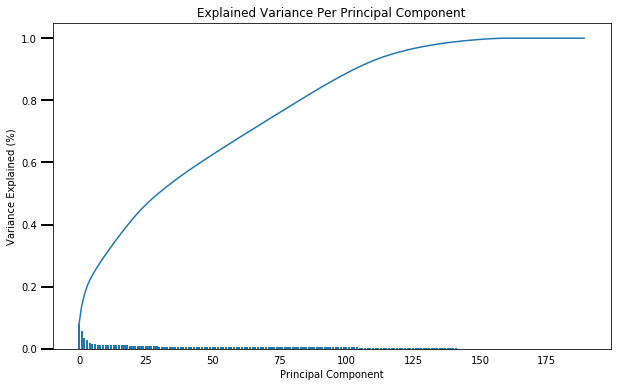

In [78]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [167]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components=110
pca, X_pca = do_pca(n_components, scaled)

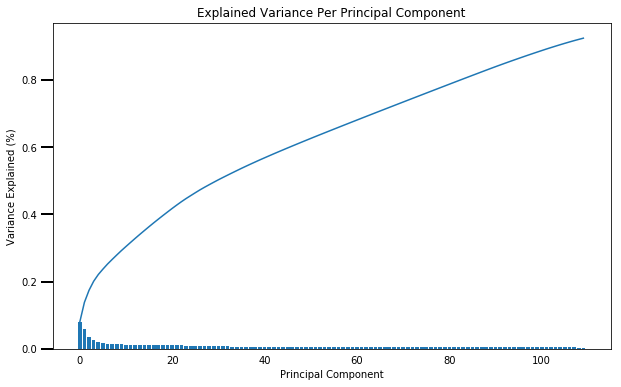

In [80]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Looking at the first scree_plot where n_components = None, it is clear that after 110 (approx), there is (almost) no variance explained anymore. Therefore it doesn't make sense to go further and we can keep 110 as the number of principal component and run the PCA again on the "scaled" data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [81]:
pd.DataFrame(pca.components_, columns=scaled.columns).head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.085300,0.014664,-0.193007,0.116289,-0.084969,0.055268,0.052510,0.150164,-0.103602,0.024073,...,0.001812,0.063929,0.043512,0.034049,0.025287,0.038936,0.057905,0.058565,0.057251,0.017043
1,0.232768,0.039143,0.086515,-0.226375,0.218938,-0.203244,-0.215225,0.088241,-0.008535,-0.050337,...,0.012266,0.016302,0.010203,0.016592,0.035273,-0.005451,0.003358,0.007371,0.013105,0.039171
2,0.016264,-0.347480,0.130549,-0.056330,0.047803,-0.151394,-0.048609,-0.061607,0.068792,-0.005273,...,0.001691,0.008689,0.017181,-0.004697,0.001016,-0.003201,0.012981,0.025379,0.012757,-0.001675
3,-0.018147,0.074187,0.010074,0.004718,-0.009041,-0.061371,0.047377,-0.034933,0.290022,-0.004780,...,-0.004732,-0.002227,0.019571,-0.014232,-0.013302,0.001578,-0.004225,0.007289,0.004277,0.001268
4,0.052440,-0.029633,0.035687,-0.026435,0.030335,0.030783,-0.107723,-0.018582,-0.169773,0.001845,...,0.002247,0.041490,-0.013412,0.055657,0.029802,0.060050,0.038169,0.014537,0.005374,-0.003572


In [82]:
def print_weights(full_dataset, pca, num_component):
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_[num_component], 4), index=full_dataset.columns)
    components.columns = ['Principal Component {}'.format(num_component+1)]
    weights=components.sort_values(by=['Principal Component {}'.format(num_component+1)],ascending=False)
    return weights

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
weights = print_weights(scaled,pca,0)
with pd.option_context('display.max_rows',10):
    print(weights)

                    Principal Component 1
LP_STATUS_GROB_1.0                 0.1968
HH_EINKOMMEN_SCORE                 0.1860
WEALTH                             0.1859
PLZ8_ANTG3                         0.1826
PLZ8_ANTG4                         0.1767
...                                   ...
KBA05_GBZ                         -0.1819
PLZ8_ANTG1                        -0.1836
KBA05_ANTG1                       -0.1898
FINANZ_MINIMALIST                 -0.1930
MOBI_REGIO                        -0.2062

[190 rows x 1 columns]


In [84]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = print_weights(scaled,pca,1)
with pd.option_context('display.max_rows',10):
    print(weights)

                       Principal Component 2
ALTERSKATEGORIE_GROB                  0.2328
FINANZ_VORSORGER                      0.2189
ZABEOTYP_3                            0.2003
SEMIO_ERL                             0.1800
SEMIO_LUST                            0.1636
...                                      ...
SEMIO_TRADV                          -0.2081
SEMIO_REL                            -0.2139
FINANZ_UNAUFFAELLIGER                -0.2152
FINANZ_SPARER                        -0.2264
DECADE                               -0.2379

[190 rows x 1 columns]


In [85]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = print_weights(scaled,pca,2)
with pd.option_context('display.max_rows',10):
    print(weights)

             Principal Component 3
SEMIO_VERT                  0.3206
SEMIO_FAM                   0.2614
SEMIO_SOZ                   0.2580
SEMIO_KULT                  0.2538
FINANZTYP_5                 0.1323
...                            ...
SEMIO_ERL                  -0.2082
SEMIO_KRIT                 -0.2679
SEMIO_DOM                  -0.2867
SEMIO_KAEM                 -0.3173
ANREDE_KZ                  -0.3475

[190 rows x 1 columns]


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
## Principal component 1
Principal component 1 has a positive relationship with:
- LP_STATUS_GROB_1.0: Social status, rough scale => 1.0 mean low income
- HH_EINKOMMEN_SCORE: Estimated household net income
- WEALTH: this is one of the feature coming from CAMEO_INTL_2015 and measure Wealth Households.

and a negative relationship with:
- MOBI_REGIO: Movement patterns: notice low score is high movement
- KBA05_ANTG1: Number of 1-2 family houses in the microcell
- FINANZ_MINIMALIST: low financial interest, notice low score is high financial topology

This principal component 1 combines income (+ financial interest), wealth of households and movements.
As income and movement have different sign and low movement score is high movement, this means, people with low income are more likely to move a lot.

## Principal component 2
Principal component 2 has a positive relationship with:
- ALTERSKATEGORIE_GROB: estimated age, the higher the older
- FINANZ_VORSORGER: financial topology: "be prepared". The higher, the lower.
- ZABEOTYP_3: energy consomption: 3 is "smart"

and a negative relationship with:
- DECADE: this is one of the feature coming from PRAEGENDE_JUGENDJAHRE and measure in which decade the person is born. The higher, the younger.
- FINANZ_SPARER: financial topology: "money saver". The higher, the lower.
- SEMIO_REL: personality typology: "religious". The higher, the lower.

This principal component 2 combines age, financial topology, energy consomption and religion.
I'm surprised to have VORSORGER and SPARER in opposite direction, since they are not that far from the dimension scale.
One learning here is: the older you are, the more religious you are.

## Principal component 3
Principal component 3 has a positive relationship with:
- SEMIO_VERT: personality "dreamful". The higher the lower
- SEMIO_FAM: personality "familiy minded". The higher the lower
- SEMIO_SOZ: personality "socially minded". The higher the lower

and a negative relationship with:
- ANREDE_KZ: gender. 1 male, 2 female
- SEMIO_KAEM: personality "combative attitude". The higher, the lower.
- SEMIO_DOM: personality "dominant minded". The higher, the lower.

This principal component 3 combines lots of personality features on top of gender.
People that are dreamfull are more likely to be familly and socially minded as well, especially if they are women.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [86]:
list(range(11,15,2))

[11, 13]

In [87]:
from sklearn.cluster import KMeans

In [88]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

# code coming from Changing_K lesson
'''
centers = list(range(11,15,2))
scores = []
for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(scaled)
    scores.append(-model.score(scaled)) 
''' 


'\ncenters = list(range(11,15,2))\nscores = []\nfor center in centers:\n    kmeans = KMeans(n_clusters=center)\n    model = kmeans.fit(scaled)\n    scores.append(-model.score(scaled)) \n'

I did split in 2 runs... really long to process on my old computer at home.

In [89]:
centers = [1, 3, 5, 7, 9, 11, 13]

In [90]:
scores = [120902546.00000006,
 109242113.83538502,
 104943716.46919034,
 102550299.22861913,
 100883223.17505988,
 99452683.7371567, 
 98123775.78830454]

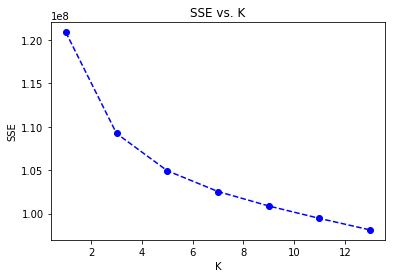

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [168]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=6)
model = kmeans.fit(X_pca)
predict = kmeans.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

I decided to split into 6 clusters since it looks like the elbow is there.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [169]:
#azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
#feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [170]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [171]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [172]:
# clean data
custo = clean_data(customers, feat_info)
#custo.dropna(axis=0, inplace=True)

C:\Users\piersjea\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [173]:
custo.shape

(141690, 192)

In [174]:
custo.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=192)

In [175]:
scaled.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=192)

In [176]:
list(set(scaled.columns)- set(custo.columns))

[]

In [177]:
# perform feature scaling
custo_imputed = my_imputer.transform(custo)
custo_scaled = my_scaler.transform(custo_imputed)
custo_scaled = pd.DataFrame(custo_scaled, columns=list(custo_imputed))
custo_scaled.columns = custo.columns

In [178]:
custo_scaled.shape

(141690, 192)

In [179]:
# do PCA
custo_pca = pca.transform(custo_scaled)

In [180]:
custo_pca.shape

(141690, 110)

In [181]:
# do prediction
custo_pred = model.predict(custo_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General population Clusters')

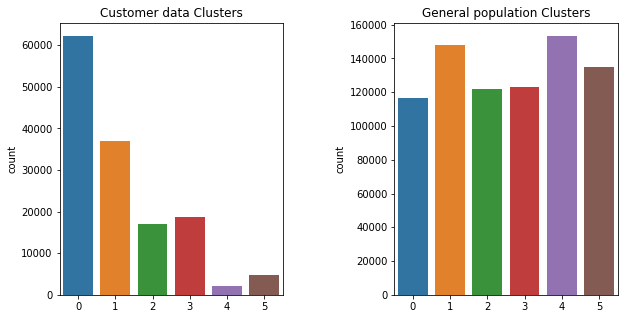

In [195]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=0.5)

sns.countplot(custo_pred, ax=axs[0])
axs[0].set_title('Customer data Clusters')
sns.countplot(predict, ax=axs[1])
axs[1].set_title('General population Clusters')



In [185]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

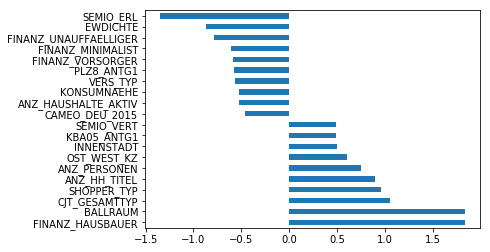

In [188]:
plot_scaled_comparison(customers, kmeans, 0)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Cluster 0 is over-represented.

There are people who are FINANZ_HAUSBAUER, BALLRAUM: they own their home and are far from urban center.


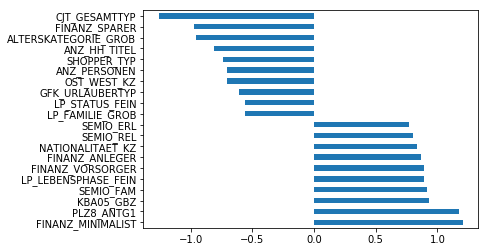

In [192]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
plot_scaled_comparison(customers, kmeans, 4)

Cluster 4 is under represented.

There are people who are FINANZ_MINIMALIST, PLZ8_ANTG1: they are very low financial interest and very high share of 1-2 family homes in the PLZ8 region.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.